# Johdanto

Tähän kirjoitetaan johdanto sovellukseen

Alkuperäinen kuva:

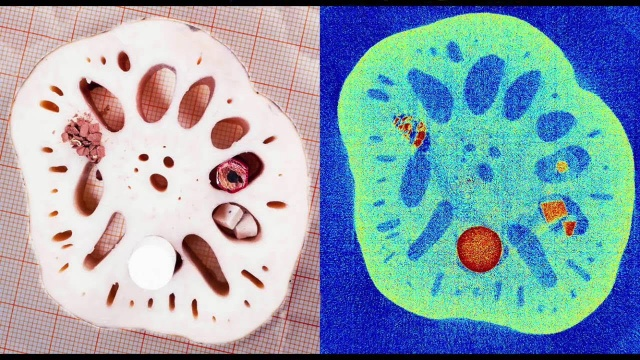

# Ympäristön alustaminen

Tämä osio tarvitsee suorittaa vain kerran. Tässä haetaan sovelluksen käyttämä mittausdata ja Total Variation rekonstruktioon tarvittava Python-moduuli. Lisäksi sovelluksen tarvitsemat Python-kirjastot otetaan käyttöön.

Rekonstruktiossa käytettävä algoritmi on ladattavissa [GitHubista](https://github.com/jaapro-git/pythonTVReconstruction).


In [ ]:
!wget -qN https://zenodo.org/record/1254204/files/LotusData256.mat
!wget -qN https://raw.githubusercontent.com/jaapro-git/pythonTVReconstruction/master/pythonTVReconstruction.py

import pythonTVReconstruction as tvr

from scipy import io as sio
import numpy as np

from sklearn.preprocessing import normalize
from skimage.transform import iradon

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import time

images = {}

# Rekonstruktioparametrit
Tässä osiossa voit käyttää neljää eri parametria muuttamaan sovelluksen muodostamien kuvien käsittelyä. Oletusasetuksilla kuvat muodostuvat nopeasti, mutta kuvien laadussa on parannettavaa. Kokeile eri parametreja ja niiden yhdistelmiä, sekä havainnoi, miten ne vaikuttavat kuvien laatuun.

Parametrien selitykset:
1.   Projektiokulmien lukumäärä

>> Tähän selitys parametrista

2.   Projektiokulmien tyyppi

>> Tähän selitys parametrista

3.   Regularisaatioparametri

>> Tähän selitys parametrista


4.   Laskentatoistojen lukumäärä

>> Tähän selitys parametrista



In [ ]:
tvr.displayParameterWidgets()

Dropdown(description='Number of Angles:', index=1, options=(('12 Angles', 12), ('20 Angles', 20), ('40 Angles'…

Dropdown(description='Type of Angles', options=(('Sparse Angles', 'sparse'), ('Dense Angles', 'dense')), value…

Dropdown(description='Regularisation Parameter:', index=1, options=(('10⁻⁶', -7), ('10⁻⁵', -5), ('10⁻⁴', -3), …

Dropdown(description='Number of Iterations:', options=(('10²', 100), ('10³', 1000), ('10⁴', 10000), ('10⁵', 10…

# Signaalin lataus ja näytteenotto

Tässä osiossa ladataan alkuperäinen signaali sekä suoritetaan annettujen parametrien mukainen näytteenotto. Jos olet muuttanut parametreja, suorita tämä osio uudelleen, jotta myöhempi käsittely tapahtuu uusien parametrien mukaisesti.

**Selitä tässä vielä**
 - **normalisointi**
 - **näytteenoton ajatus**

In [ ]:
# Load necessary matrices from the Matlab data file
sinogram120 = sio.loadmat('LotusData256.mat', mat_dtype = True).get('m')
measurement120 = sio.loadmat('LotusData256.mat', mat_dtype = True).get('A')

# Normalize the matrices
sinogram120 = normalize(sinogram120, axis=0, norm='l1')
measurement120 = normalize(measurement120, axis=0, norm='l1')

# Get sampling parameters
angles = int(tvr.anglesSelector.value)
sampleRate = int(120 / angles)
#print(str(angles) + ',' + str(sampleRate))

[m, n] = sinogram120.shape
ind = np.empty(0, dtype = np.int8)

# Sample the original data according to the set parameters
if tvr.angleTypeSelector.value == 'sparse':
  # Sample angles in even steps
  for i in range(angles):
    begin = (sampleRate * i) * m
    end = ((sampleRate * i + 1) * (m + 1) - i * sampleRate) -1 #IMPROVEME
    #print(str(begin) + '-' + str(end))
    new = np.arange(begin,end)
    ind = np.append(ind, new)
  
  # Use the sampled angles of the measurement matrix
  measurementSample = measurement120[ind,:]
  # Use every nth column of the sinogram data, where n is the sample rate
  sinogramSample = sinogram120[:, ::sampleRate]
else:
  # Sample in four dense clusters
  for i in range(4): # The largest common factors of the selectable angles
    begin = int(angles / 4) * (sampleRate * i) * m
    end = begin + int(angles / 4) * m
    #print(str(begin) + '-' + str(end))
    new = np.arange(begin,end)
    ind = np.append(ind, new)

  # Use the sampled angles of the measurement matrix
  measurementSample = measurement120[ind,:]
  sinogramSample = np.empty((m, 0))
  # Use...
  for i in range(4):
    begin = (i * int(angles / 4) * int(120 / angles)) #IMPROVEME
    end = (i * int(angles / 4) * int(120 / angles)) + int(angles / 4) #IMPROVEME
    #print(str(begin) + '-' + str(end))
    sinogramSample = np.hstack((sinogramSample, sinogram120[:,begin:end]))

# Add sinograms into the image dict
images.update({'sinogram120' : sinogram120})
images.update({'sinogramSample' : sinogramSample})

# Takaisinprojektio
Tehdään takaisinprojektio käyttäen käänteistä Radon-transformaatiota.

**Laita tähän linkki sopivaan videoon ja selitä lisää.**

In [ ]:
# Reconstruct the sinogram using filtered back project
theta120 = np.linspace(0., 360., 120, endpoint=False)
thetaSample = np.linspace(0., 360., angles, endpoint=False)

#fbp120 = iradon(sinogram120, theta=theta120, circle=False)
#fbpSample = iradon(sinogramSample, theta=thetaSample, circle=False)

# Reconstruct and add to image dict
images.update({'fbp120' : iradon(sinogram120, theta=theta120, circle=False)})
images.update({'fbpSample' : iradon(sinogramSample, theta=thetaSample, circle=False)})

# Total Variation -regularisaatio

**Selitä tässä Total Variation -regularisaatio yksinkertaistetusti ja laita linkki sopivaan videoon**

Laskenta Google Colab:ssa kestää noin 30 min, kun iteraatioita on 10000.

In [ ]:
alpha = pow(10, tvr.alphaSelector.value)
iterations = tvr.iterationsSelector.value

# Execute the reconstruction algorithm for the full resolution data and sample data comparing different number of iterations
tic = time.perf_counter()
# 1 iteration
images.update({'tvImgFull1' : tvr.reconstructTotalVariation(sinogram120, measurement120, 2, alpha, 1)})
images.update({'tvImgSample1' : tvr.reconstructTotalVariation(sinogramSample, measurementSample, 2, alpha, 1)})

# 10 iterations
images.update({'tvImgFull10' : tvr.reconstructTotalVariation(sinogram120, measurement120, 2, alpha, 10)})
images.update({'tvImgSample10' : tvr.reconstructTotalVariation(sinogramSample, measurementSample, 2, alpha, 10)})

# Selected number of iterations
images.update({'tvImgFullMax' : tvr.reconstructTotalVariation(sinogram120, measurement120, 2, alpha, iterations)})
images.update({'tvImgSampleMax' : tvr.reconstructTotalVariation(sinogramSample, measurementSample, 2, alpha, iterations)})
toc = time.perf_counter()
print(f"Operation lasted {toc - tic:0.4f} seconds")

IntProgress(value=0, bar_style='info', description='Progress:', max=1)

IntProgress(value=0, bar_style='info', description='Progress:', max=1)

IntProgress(value=0, bar_style='info', description='Progress:', max=10)

IntProgress(value=0, bar_style='info', description='Progress:', max=10)

IntProgress(value=0, bar_style='info', description='Progress:', max=10000)

IntProgress(value=0, bar_style='info', description='Progress:', max=10000)

Operation lasted 1998.2591 seconds


# Tulosten vertailu
Alapuolelle tulostuvat muiden osoiden suorittamisen perusteella rakennetut kuvat. Vertaa erityisesti toisessa ja kolmannessa sarakkeissa olevia kuvia keskenään.

Ensimmäisessä sarakkeessa on visualisoitu sinogrammit ennen ja jälkeen näytteenoton.

Toisen sarakkeen kuvissa ilmenee projektiokulmien ja niiden tyypin vaikutus kuvan laatuun.

Kolmannessa sarakkeessa voidaan havaita Total Variation -regularisaation tuottama parannus verrattuna pelkkään takaisinprojektioon.

Viimeisessä kahdessa sarakkeessa on nähtävillä Total Variation -regularisaation tuottama kuva pienillä toistomäärillä. Vertaamalla näitä kolmannen sarakkeen kuvaan, voidaan havaita toistojen lukumäärän vaikutus kuvan laatuun.



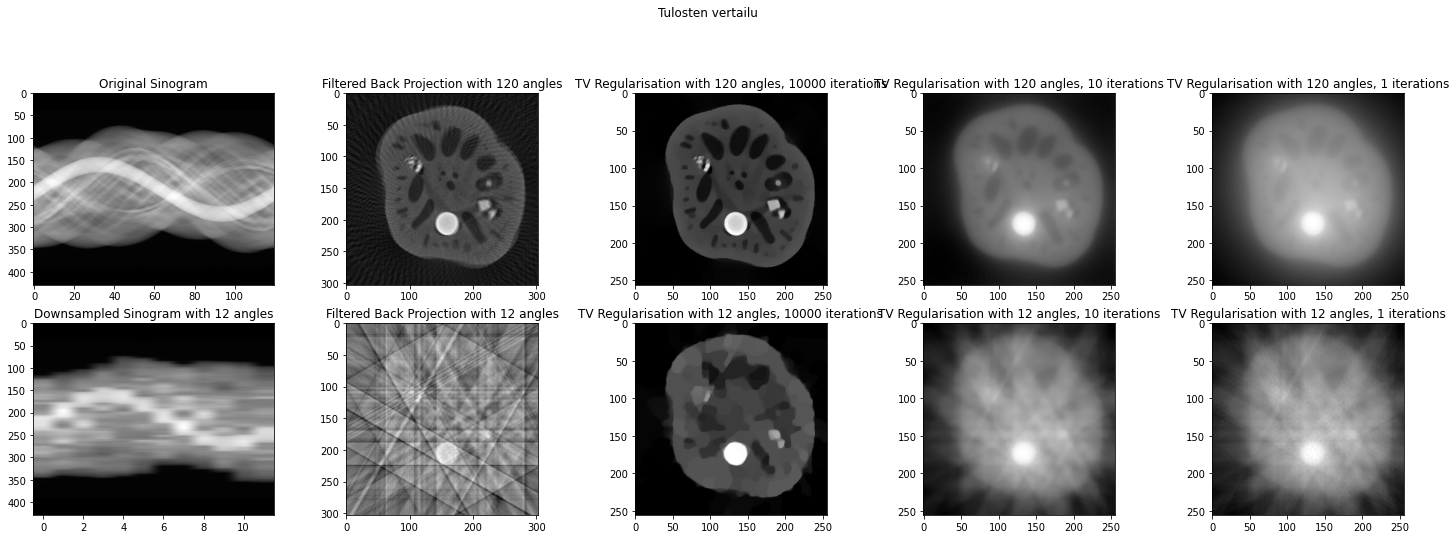

In [ ]:
# Call a helper function to draw the plots and save some space here...
tvr.drawPlots(images, angles, iterations)